# Домашнее задание 1

- Дисциплина: Нейронные сети и обработка текстов
- Тема: Классификация текстов по тональности
- Студент: Новиков Руслан
- Группа: ФН12-31М


#### IMDb 50K Cleaned Movie Reviews

[Ссылка](https://www.kaggle.com/datasets/ibrahimqasimi/imdb-50k-cleaned-movie-reviews) на датасет


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, f1_score
from tqdm.notebook import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
DATA_PATH = "./data/"
FILE = "IMDB_cleaned.csv"
PATH_FILE = DATA_PATH + FILE

dataset = pd.read_csv(PATH_FILE)

display(dataset)

,review,cleaned_review,sentiment
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...,positive
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,basically there is a family where a little boy...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei s love in the time of money is a...,positive
...,...,...,...
4995,An interesting slasher film with multiple susp...,an interesting slasher film with multiple susp...,negative
4996,i watched this series when it first came out i...,i watched this series when it first came out i...,positive
4997,Once again Jet Li brings his charismatic prese...,once again jet li brings his charismatic prese...,positive
4998,"I rented this movie, after hearing Chris Gore ...",i rented this movie after hearing chris gore s...,negative


# 1. Нормализуйте текст.


В описании датасета сказано, что текст уже очищен. Также указано, как именно производилась очистка, этот процесс может быть воспроизведён повторно.

Поэтому, чтобы не тратить время на выполнение указанных действий для получения схожих результатов, восползуемся уже имеющимися достижениями.

Таким образом, можно считать, что задание 1 выполнено автоматически - нормализованный текст уже лежит в колонке "cleaned_review".


# 2. Разбейте его на трейн/тест.

- Если датасет слишком большой, то оставьте не больше 10к — 100к примеров.


В датасете 5000 объектов, поэтому будем использовать его целиком.


In [3]:
dataset["sentiment"].value_counts()

sentiment
negative    2532
positive    2468
Name: count, dtype: int64

Видно, что датасет сбалансирован по классам


In [4]:
# Переведём столбец "sentiment" в числовой формат
# "negative" -> 0
# "positive" -> 1

dataset["y_sentiment"] = dataset["sentiment"]
replace_dict = {
    "negative": "0",
    "positive": "1",
}
dataset["y_sentiment"] = dataset["y_sentiment"].replace(replace_dict)
dataset["y_sentiment"] = pd.to_numeric(dataset["y_sentiment"])

dataset["y_sentiment"]

0       1
1       1
2       1
3       0
4       1
       ..
4995    0
4996    1
4997    1
4998    0
4999    0
Name: y_sentiment, Length: 5000, dtype: int64

In [5]:
X = dataset["cleaned_review"].values
y = dataset["y_sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

# 3. Обучите логистическую регрессию стохастическим градиентным спуском, используя tf-idf в качестве факторов.

- Редкие слова удалите.
- Проанализируйте, какие слова получили наибольши вес.
- Попробуйте лемматизировать слова.
- Нарисуйте loss на графике на трейне и на тесте (например, с помощью библиотеки matplotlib).
- Посчитайте метрику accuracy, F-1 (macro/micro для задачи мультиклассификации). Для задачи регрессии используйте MAE, MSE/RMSE.


In [6]:
vectorizer = TfidfVectorizer(min_df=5)
X_train_tf_idf = vectorizer.fit_transform(X_train)
X_test_tf_idf = vectorizer.transform(X_test)

Используя параметр `min_df=5`, мы не будем использовать слова, которые встречались менее, чем в 5 документах (в нашем случае, документ - это movie reviews, рецензия на фильм).

Таким образом, задание "Редкие слова удалите" (см. далее) - выполнено.


In [ ]:
class LogisticRegressionWrapper:
    def __init__(
        self,
        clf: SGDClassifier,
        name: str = "model",
    ) -> None:
        self.clf = clf
        self.output_dir = "../checkpoints/logistic_regression"
        self.name = name
        self.train_losses = []
        self.test_losses = []
        self.accuracy_scores = []
        self.f1_scores = []

    def fit(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        n_epochs: int = 100,
    ) -> None:
        classes = np.unique(y_train)

        for _ in tqdm(range(n_epochs)):
            self.clf.partial_fit(X=X_train, y=y_train, classes=classes)

            y_proba = self.clf.predict_proba(X=X_train)
            loss = log_loss(y_train, y_proba)
            self.train_losses.append(loss)

            y_proba_test = self.clf.predict_proba(X_test)
            loss_test = log_loss(y_test, y_proba_test)
            self.test_losses.append(loss_test)

            y_pred = self.clf.predict(X=X_test)
            accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
            self.accuracy_scores.append(accuracy)
            f1 = f1_score(y_true=y_test, y_pred=y_pred)
            self.f1_scores.append(f1)

    def predict(self, X_test, y_test):
        return self.clf.predict(X=X_test, y=y_test)

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label="Training Log Loss")
        plt.plot(self.test_losses, label="Testing Log Loss")

        plt.xlabel("Epoch")
        plt.ylabel("Log Loss")
        plt.title("Log Loss for Logistic Regression")

        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_metrics(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.accuracy_scores, label="Trest accuracy")
        plt.plot(self.f1_scores, label="Test f1")

        plt.xlabel("Epoch")
        plt.ylabel("Metrics")
        plt.title("Metrics for Logistic Regression")

        plt.grid(True)
        plt.legend()
        plt.show()

    def save(self):
        output_path = Path(self.output_dir)
        output_path.mkdir(parents=True, exist_ok=True)

        with open(f"{self.output_dir}/{self.name}.pkl", "wb") as f:
            pickle.dump(self.clf, f)

    def load(self, name: str):
        with open(f"{self.output_dir}/{name}.pkl", "rb") as f:
            self.clf = pickle.load(f)
            self.name = name

  0%|          | 0/500 [00:00<?, ?it/s]

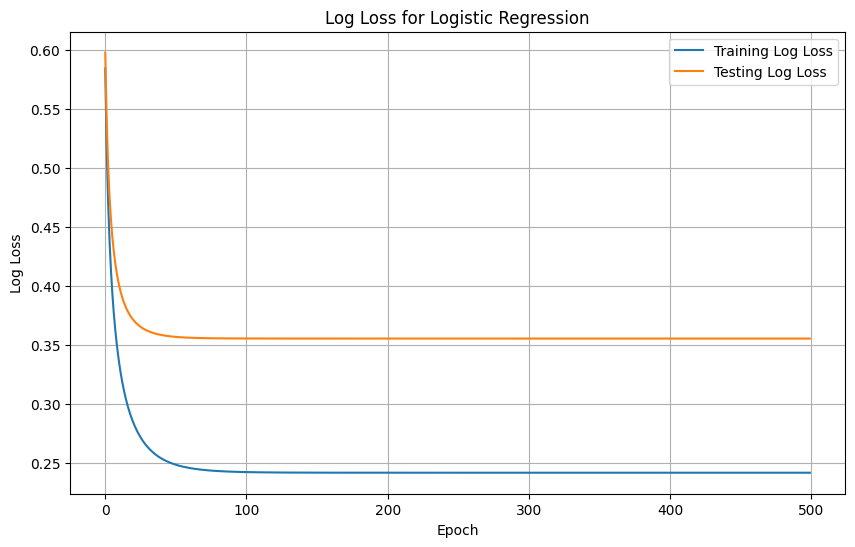

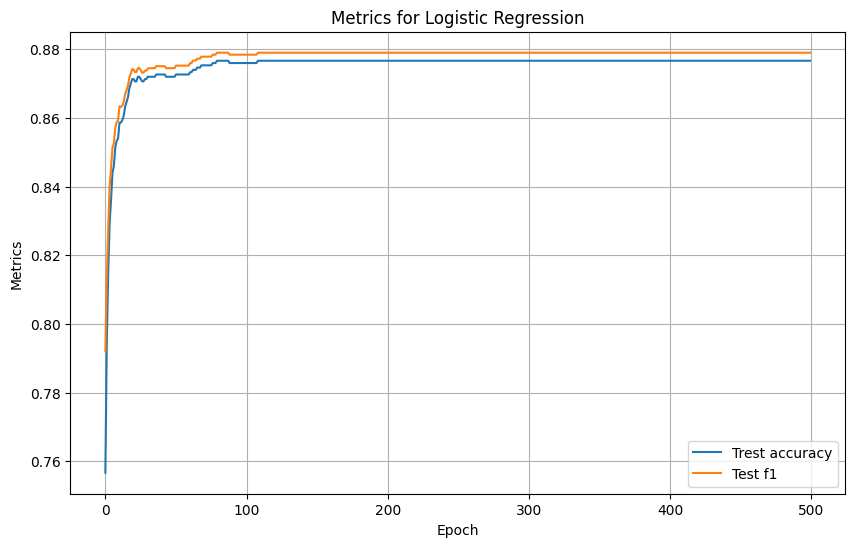

In [8]:
logreg_no_penalty = LogisticRegressionWrapper(
    clf=SGDClassifier(
        loss="log_loss",
        learning_rate="constant",
        eta0=0.1,
        random_state=0,
        warm_start=True,
    ),
    name="no_penalty",
)

logreg_no_penalty.fit(
    X_train=X_train_tf_idf,
    y_train=y_train,
    X_test=X_test_tf_idf,
    y_test=y_test,
    n_epochs=500,
)

logreg_no_penalty.save()

logreg_no_penalty.plot_losses()
logreg_no_penalty.plot_metrics()

In [9]:
feature_names = vectorizer.get_feature_names_out()
coef = logreg_no_penalty.clf.coef_

print("Слова, получившие наибольшие веса:")

top_positive_idx = np.argsort(coef[0])[-10:]
top_negative_idx = np.argsort(coef[0])[:10]
print("Positive:", [feature_names[i] for i in top_positive_idx])
print("Negative:", [feature_names[i] for i in top_negative_idx])

Слова, получившие наибольшие веса:
Positive: ['favorite', 'still', 'wonderful', 'and', 'love', 'perfect', 'loved', 'best', 'excellent', 'great']
Negative: ['bad', 'worst', 'no', 'waste', 'boring', 'awful', 'nothing', 'poor', 'instead', 'plot']


# 4. Поэкспериментируйте с весом в L1 регуляризации.

- Сравните обученную новым способ логистическую регрессию с ранее обученным вариантом. Что лучше? Какие веса занулились?
- Нарисуйте графики.
- Посчитайте те же метрики.


  0%|          | 0/500 [00:00<?, ?it/s]

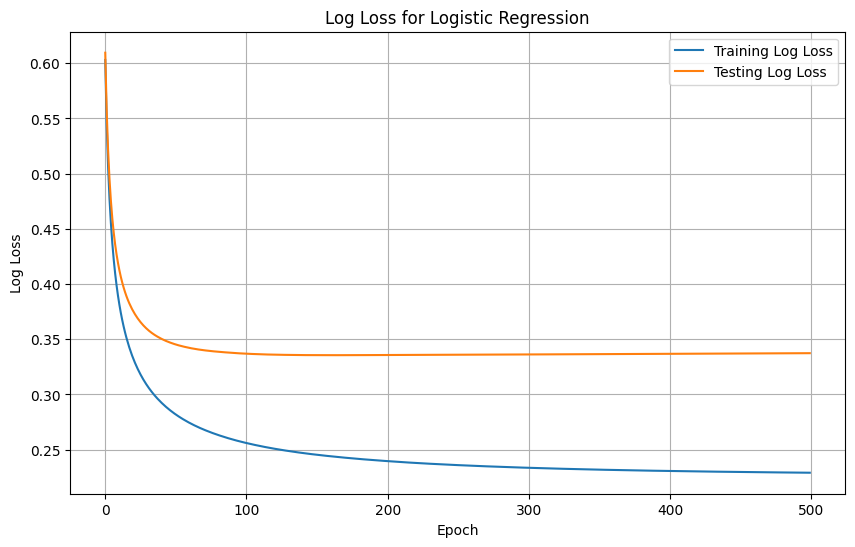

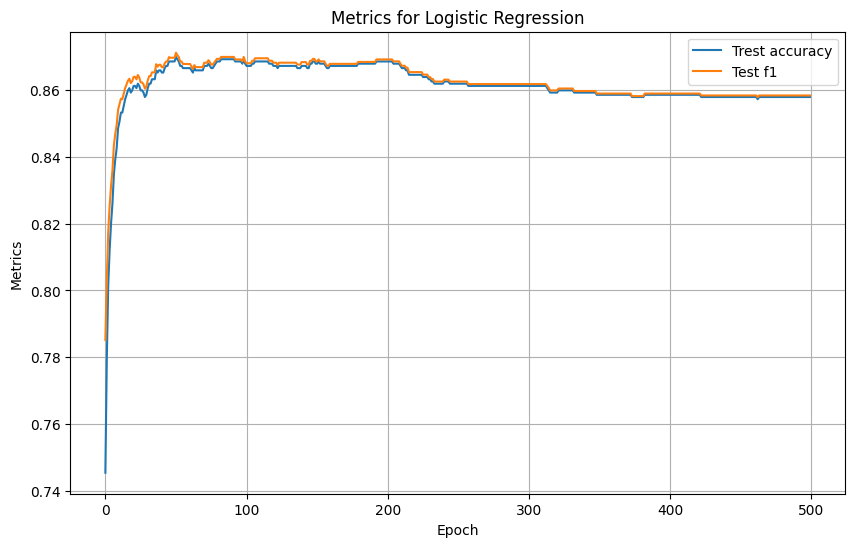

In [10]:
logreg_l1_penalty = LogisticRegressionWrapper(
    clf=SGDClassifier(
        loss="log_loss",
        learning_rate="constant",
        eta0=0.1,
        random_state=0,
        warm_start=True,
        penalty="l1",
        alpha=0.0001,
    ),
    name="l1_penalty",
)

logreg_l1_penalty.fit(
    X_train=X_train_tf_idf,
    y_train=y_train,
    X_test=X_test_tf_idf,
    y_test=y_test,
    n_epochs=500,
)

logreg_l1_penalty.save()

logreg_l1_penalty.plot_losses()
logreg_l1_penalty.plot_metrics()

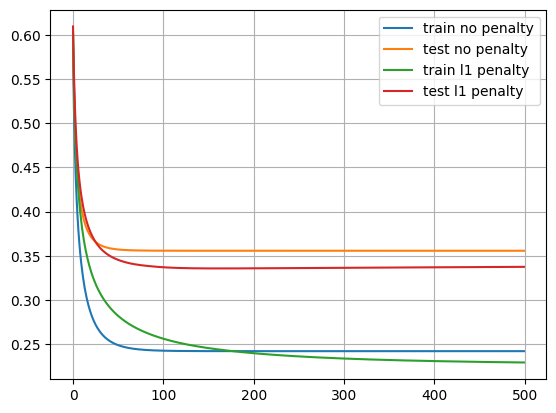

In [11]:
plt.plot(logreg_no_penalty.train_losses, label="train no penalty")
plt.plot(logreg_no_penalty.test_losses, label="test no penalty")

plt.plot(logreg_l1_penalty.train_losses, label="train l1 penalty")
plt.plot(logreg_l1_penalty.test_losses, label="test l1 penalty")

plt.grid()
plt.legend()
plt.show()

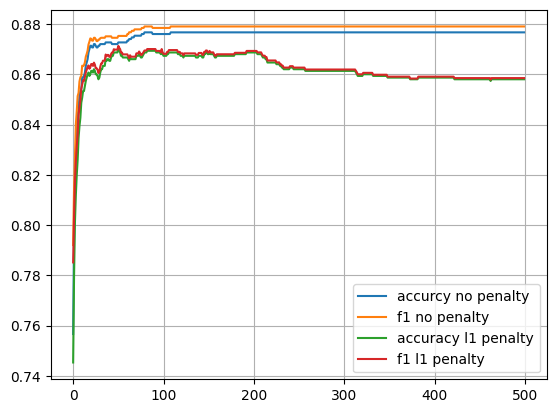

In [12]:
plt.plot(logreg_no_penalty.accuracy_scores, label="accurcy no penalty")
plt.plot(logreg_no_penalty.f1_scores, label="f1 no penalty")

plt.plot(logreg_l1_penalty.accuracy_scores, label="accuracy l1 penalty")
plt.plot(logreg_l1_penalty.f1_scores, label="f1 l1 penalty")

plt.grid()
plt.legend()
plt.show()

In [13]:
for model in [logreg_no_penalty, logreg_l1_penalty]:
    print(f"Model: {model.name}")
    print(f"Accuracy: {model.accuracy_scores[-1]}")
    print(f"F1: {model.f1_scores[-1]}")
    print()

Model: no_penalty
Accuracy: 0.8766666666666667
F1: 0.8790058862001308

Model: l1_penalty
Accuracy: 0.858
F1: 0.8584717607973422



# 5. Обучите нейронную сеть с помощью библиотеки torch с одним скрытым слоем, используя tf-idf над лемматизированными словами.

- Редкие слова удалите.
- Нарису те loss на трейн и тесте на графике.
- Сравните лоссы обученные с разными инициализациями: нулевая, xavier, he.
- В качестве функции активации используйте ReLU.
- Посчитайте те же метрики.


In [14]:
X_train_dense = X_train_tf_idf.toarray()
X_train_tensor = torch.from_numpy(X_train_dense).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_test_dense = X_test_tf_idf.toarray()
X_test_tensor = torch.from_numpy(X_test_dense).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        init_type: str,
    ) -> None:
        super(NeuralNetwork, self).__init__()

        output_dim = 1

        self.fc_1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.act_1 = nn.ReLU()
        self.fc_2 = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self.sigmoid = nn.Sigmoid()

        self._init_weights(init_type)

    def _init_weights(self, init_type: str) -> None:
        match init_type:
            case "zero":
                init.zeros_(self.fc_1.weight)
                init.zeros_(self.fc_2.weight)
                init.zeros_(self.fc_1.bias)
                init.zeros_(self.fc_2.bias)

            case "xavier":
                init.xavier_uniform_(self.fc_1.weight)
                init.xavier_uniform_(self.fc_2.weight)
                init.zeros_(self.fc_1.bias)
                init.zeros_(self.fc_2.bias)

            case "he":
                init.kaiming_uniform_(self.fc_1.weight, nonlinearity="relu")
                init.kaiming_uniform_(self.fc_2.weight, nonlinearity="sigmoid")
                init.zeros_(self.fc_1.bias)
                init.zeros_(self.fc_2.bias)

            case _:
                raise ValueError(f"Неизвестный тип инициализации: {init_type}")

    def forward(
        self,
        X: torch.tensor,
    ) -> torch.tensor:
        fc_1_output = self.fc_1(X)
        act_1_output = self.act_1(fc_1_output)
        fc_2_output = self.fc_2(act_1_output)
        return fc_2_output

    def predict_proba(
        self,
        X: torch.tensor,
    ) -> torch.tensor:
        logit = self.forward(X=X)
        output = self.sigmoid(logit)
        return output

    def predict(
        self,
        X: torch.tensor,
    ) -> torch.tensor:
        proba = self.predict_proba(X=X)
        pred = (proba >= 0.5).int()
        return pred


In [ ]:
class NeuralNetworkWrapper:
    def __init__(
        self,
        model: NeuralNetwork,
        name: str = "model",
    ) -> None:
        self.model = model
        self.name = name
        self.train_losses = []
        self.test_losses = []
        self.accuracy_scores = []
        self.f1_scores = []
        self.output_dir = "../checkpoints/neural_network"

    def fit(
        self,
        X_train: torch.tensor,
        y_train: torch.tensor,
        X_test: torch.tensor,
        y_test: torch.tensor,
        epochs: int = 100,
        batch_size: int = 32,
        lr: float = 0.01,
        device: str = "cpu",
    ) -> None:
        train_dataset = TensorDataset(X_train, y_train)
        train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )

        test_dataloader = TensorDataset(X_test, y_test)
        test_dataloader = DataLoader(
            test_dataloader, batch_size=batch_size, shuffle=True
        )

        self.model.to(device)
        self.model.train()

        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()

        for _ in tqdm(range(epochs)):
            epoch_train_loss = 0.0
            for X_batch, y_batch in train_dataloader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device).unsqueeze(1)  # (batch,) -> (batch, 1)

                # Прямой проход
                logits = self.model(X_batch)
                train_loss = criterion(logits, y_batch)

                # Обратное распространение
                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()

                epoch_train_loss += train_loss.item()

            self.train_losses.append(epoch_train_loss)

            epoch_test_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in test_dataloader:
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device).unsqueeze(1)  # (batch,) -> (batch, 1)

                    logits = self.model(X_batch)
                    test_loss = criterion(logits, y_batch)

                    epoch_test_loss += test_loss.item()

            self.test_losses.append(epoch_test_loss)

            # Плохо, что здесь делаю predict для всего X_test, а не по батчам (как в цикле выше)
            # Поскольку датасет не очень большой, то в текущей ситуации можно так сделать
            # Но для большего датасета пришлось бы прописывать цикл
            # Получается, что это - точка роста
            y_pred = self.model.predict(X=X_test)
            y_pred = y_pred.detach().numpy()
            accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
            self.accuracy_scores.append(accuracy)
            f1 = f1_score(y_true=y_test, y_pred=y_pred)
            self.f1_scores.append(f1)

    def predict_proba(
        self,
        X_test: torch.tensor,
    ) -> torch.tensor:
        return self.model.predict_proba(X=X_test)

    def predict(
        self,
        X_test: torch.tensor,
    ) -> torch.tensor:
        return self.model.predict(X=X_test)

    def plot_training_info(self):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

        losses_ax = ax[0]
        losses_ax.plot(self.train_losses, label="Training Loss")
        losses_ax.plot(self.test_losses, label="Testing Loss")
        losses_ax.set_xlabel("Epoch")
        losses_ax.set_ylabel("Loss")
        losses_ax.set_title("Loss for Neural Network")

        metrics_ax = ax[1]
        metrics_ax.plot(self.accuracy_scores, label="Testing accuracy")
        metrics_ax.plot(self.f1_scores, label="Testing F1")
        metrics_ax.set_xlabel("Epoch")
        metrics_ax.set_ylabel("Metrics")
        metrics_ax.set_title("Metrics for Neural Network")

        plt.grid(True)
        plt.legend()
        plt.show()

    def save(self):
        output_path = Path(self.output_dir)
        output_path.mkdir(parents=True, exist_ok=True)

        torch.save(self.model.state_dict(), f"{self.output_dir}/{self.name}.pth")

    def load(self, name: str):
        self.model.load_state_dict(
            torch.load(f=f"{self.output_dir}/{name}.pth", weights_only=True)
        )
        self.name = name

  0%|          | 0/10 [00:00<?, ?it/s]

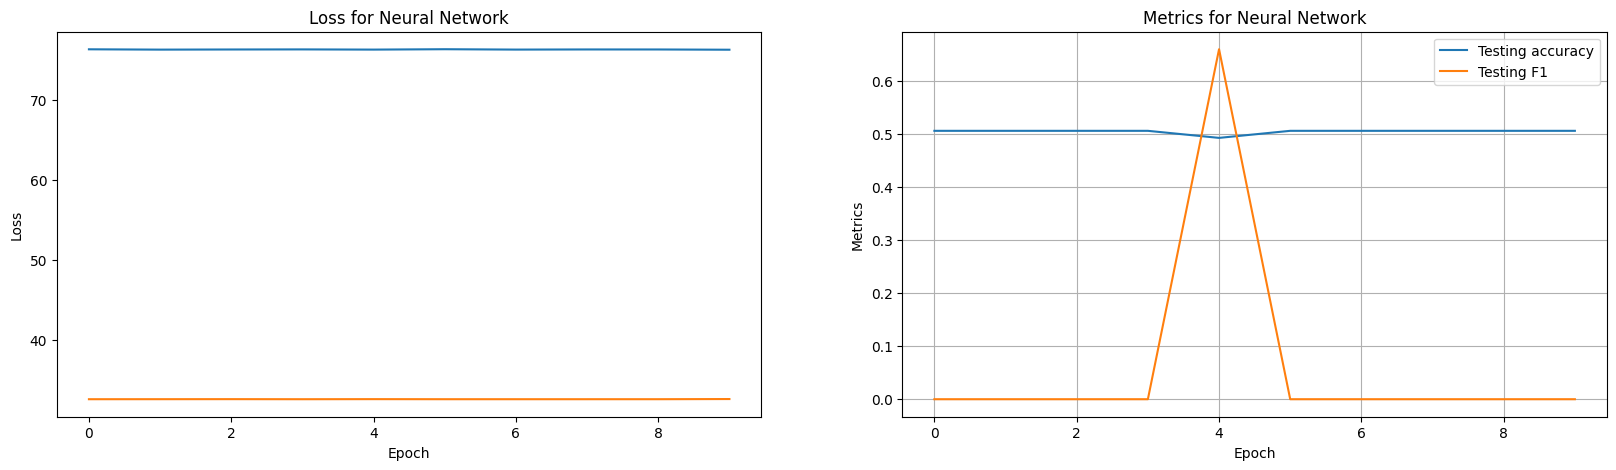

In [17]:
init_type = "zero"

nn_zero = NeuralNetworkWrapper(
    model=NeuralNetwork(
        input_dim=X_train_tensor.shape[1],
        hidden_dim=64,
        init_type=init_type,
    ),
    name=init_type,
)

nn_zero.fit(
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    epochs=10,
)
nn_zero.save()

nn_zero.plot_training_info()

  0%|          | 0/10 [00:00<?, ?it/s]

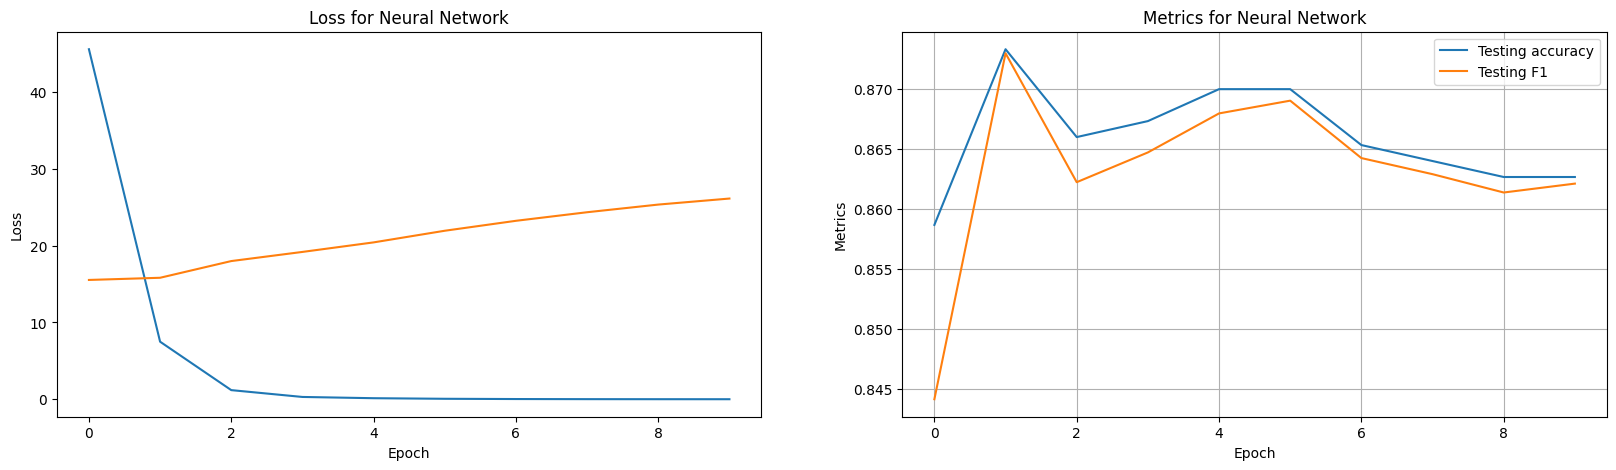

In [18]:
init_type = "xavier"

nn_xavier = NeuralNetworkWrapper(
    model=NeuralNetwork(
        input_dim=X_train_tensor.shape[1],
        hidden_dim=64,
        init_type=init_type,
    ),
    name=init_type,
)

nn_xavier.fit(
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    epochs=10,
)
nn_xavier.save()

nn_xavier.plot_training_info()

  0%|          | 0/10 [00:00<?, ?it/s]

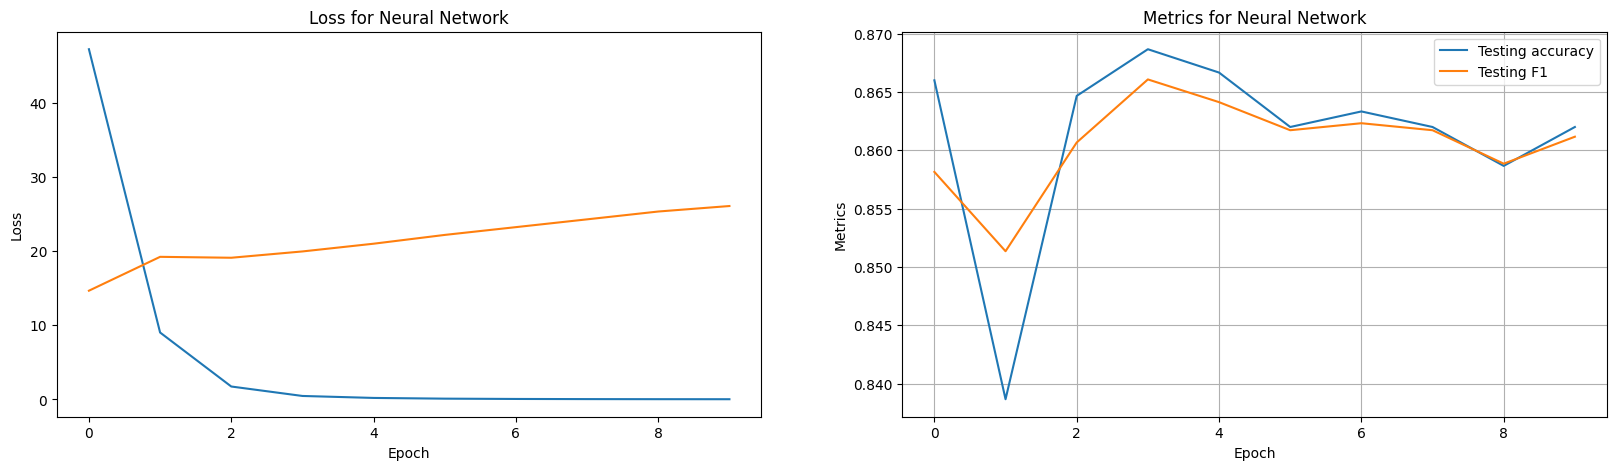

In [19]:
init_type = "he"

nn_he = NeuralNetworkWrapper(
    model=NeuralNetwork(
        input_dim=X_train_tensor.shape[1],
        hidden_dim=64,
        init_type=init_type,
    ),
    name=init_type,
)

nn_he.fit(
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    epochs=10,
)
nn_he.save()

nn_he.plot_training_info()

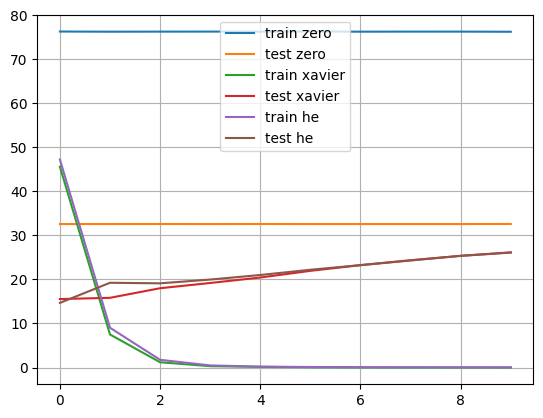

In [20]:
plt.plot(nn_zero.train_losses, label="train zero")
plt.plot(nn_zero.test_losses, label="test zero")

plt.plot(nn_xavier.train_losses, label="train xavier")
plt.plot(nn_xavier.test_losses, label="test xavier")

plt.plot(nn_he.train_losses, label="train he")
plt.plot(nn_he.test_losses, label="test he")

plt.grid()
plt.legend()
plt.show()

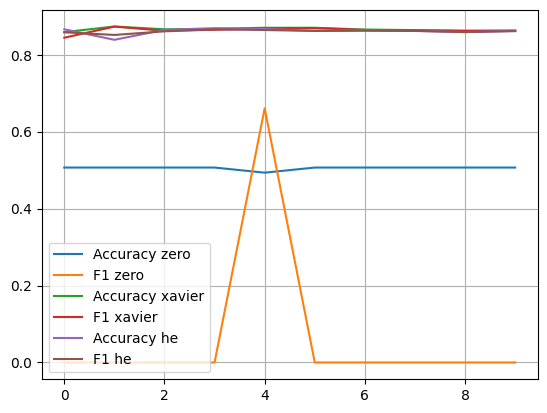

In [21]:
plt.plot(nn_zero.accuracy_scores, label="Accuracy zero")
plt.plot(nn_zero.f1_scores, label="F1 zero")

plt.plot(nn_xavier.accuracy_scores, label="Accuracy xavier")
plt.plot(nn_xavier.f1_scores, label="F1 xavier")

plt.plot(nn_he.accuracy_scores, label="Accuracy he")
plt.plot(nn_he.f1_scores, label="F1 he")

plt.grid()
plt.legend()
plt.show()

In [22]:
for model in [nn_zero, nn_xavier, nn_he]:
    print(f"Model: {model.name}")
    print(f"Accuracy: {model.accuracy_scores[-1]}")
    print(f"F1: {model.f1_scores[-1]}")
    print()

Model: zero
Accuracy: 0.5066666666666667
F1: 0.0

Model: xavier
Accuracy: 0.8626666666666667
F1: 0.8621151271753681

Model: he
Accuracy: 0.862
F1: 0.8611670020120724



# 6. Зафиксируйте лучшее решение по ранее упомянутым метрикам.


In [23]:
for model in [logreg_no_penalty, logreg_l1_penalty]:
    print(f"Model: {model.name}")
    print(f"Accuracy: {model.accuracy_scores[-1]}")
    print(f"F1: {model.f1_scores[-1]}")
    print()

Model: no_penalty
Accuracy: 0.8766666666666667
F1: 0.8790058862001308

Model: l1_penalty
Accuracy: 0.858
F1: 0.8584717607973422



In [24]:
for model in [nn_zero, nn_xavier, nn_he]:
    print(f"Model: {model.name}")
    print(f"Accuracy: {model.accuracy_scores[-1]}")
    print(f"F1: {model.f1_scores[-1]}")
    print()

Model: zero
Accuracy: 0.5066666666666667
F1: 0.0

Model: xavier
Accuracy: 0.8626666666666667
F1: 0.8621151271753681

Model: he
Accuracy: 0.862
F1: 0.8611670020120724



Можно заметить, что все модели имеют приблизительно схожие результаты, за исключением **нейронной сети с нулевой инициализацией весов**.

Из всех моделей наилучшие показатели метрик были достигнуты у **логистической регрессии** без регуляризации.


# 7. В случае наличия дополнительных полезных нетекстовых данных для предсказания (площадь жилья, время отправки сообщения и т.п.) попробуйте заиспользовать их в подходе, показавшим наилучшее качество.

- Напишите, если таких данных в датасете не оказалось.


Дополнительных нетекстовых данных в датасете не оказалось - были только текстовые данные
